In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import datetime
import scipy.stats as stats

#graphing
import matplotlib.pyplot as plt
#stats
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel

#import testing
import sys
sys.path.append("../")
import selection_tests

In [2]:
#need to replicate table 3?
school_data = pd.read_stata('aerdata_colombia2.dta')
#keep if checkid==1 & age>=9 & age<=25
school_data = school_data[(school_data['checkid']==1) &
                          (school_data['age']>=9) & (school_data['age']<=25) ]
print(school_data.describe())

            vouch0     sex_name      match_i     match_ic     match_i7  \
count  3542.000000  3542.000000  3542.000000  3542.000000  3542.000000   
mean      0.585263     0.494918     0.354037     0.338509     0.331451   
std       0.492746     0.500045     0.478288     0.473269     0.470801   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       1.000000     0.000000     0.000000     0.000000     0.000000   
75%       1.000000     1.000000     1.000000     1.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

               age        phone  checkid         math         read  \
count  3542.000000  3542.000000   3542.0  3541.000000  3541.000000   
mean     12.670243     0.886222      1.0    14.713037    16.355835   
std       1.295708     0.317586      0.0    20.436213    22.758410   
min      10.000000     0.000000      1.0     0.000000

47.35569381713867
37.304710388183594


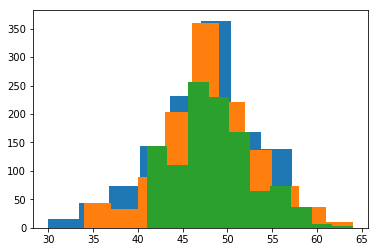

In [3]:
plt.hist(school_data['read'][school_data['read']>0])

cutoff = stats.mode(school_data['readcens1'])[0][0]
plt.hist(school_data['readcens1'][school_data['readcens1']>cutoff])

cutoff = stats.mode(school_data['readcens10'])[0][0]
plt.hist(school_data['readcens10'][school_data['readcens10']>cutoff])

print(school_data['read'][school_data['read']>0].mean())
print(school_data['readcens1'].mean())

In [5]:
# Fit the model with ols = True
x_names =['vouch0', 'age', 'sex_name'] 
y_name = 'readcens10'
#different datasets
cutoff = stats.mode(school_data[y_name])[0][0]
school_nozeros = school_data[ (school_data[y_name]> cutoff) ]


#setup x/y for missing data models
x = sm.add_constant(school_nozeros[x_names].copy())
y = school_nozeros[y_name]

ols_model = sm.OLS(y,x).fit()
print(ols_model.summary())

#setup x/y for missing data models
x = school_data[x_names].copy()
y = school_data[y_name]

x = sm.add_constant(x[~np.isnan(y)])
y = y[~np.isnan(y)]

                            OLS Regression Results                            
Dep. Variable:             readcens10   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     8.256
Date:                Thu, 24 Jun 2021   Prob (F-statistic):           1.96e-05
Time:                        17:11:34   Log-Likelihood:                -3156.4
No. Observations:                1091   AIC:                             6321.
Df Residuals:                    1087   BIC:                             6341.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         56.4678      2.045     27.611      0.0

In [6]:
tobit_model = selection_tests.Tobit(y,x, cc=True).fit()

#why is there randomly a missing observation?
print(tobit_model.summary(title='OLS CC').as_latex())



Optimization terminated successfully.
         Current function value: 1.146240
         Iterations: 102
         Function evaluations: 173
\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &     readcens10     & \textbf{  Log-Likelihood:    } &   -4058.8   \\
\textbf{Model:}            &       Tobit        & \textbf{  AIC:               } &     8126.   \\
\textbf{Method:}           & Maximum Likelihood & \textbf{  BIC:               } &     8150.   \\
\textbf{Date:}             &  Thu, 24 Jun 2021  & \textbf{                     } &             \\
\textbf{Time:}             &      17:11:34      & \textbf{                     } &             \\
\textbf{No. Observations:} &         3541       & \textbf{                     } &             \\
\textbf{Df Residuals:}     &         3537       & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                   & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{

In [7]:
# Fit the model with ols = False
tobit_model = selection_tests.Tobit(y,x).fit()

def marginal_effect(params,ys,xs):
    cutoff = stats.mode(ys)[0][0]
    mux =  np.matmul(np.array(xs),params[0:-1]) 
    return (stats.norm.cdf(mux/np.sqrt(np.abs(params[-1])))*params[1]).mean()

def avg_effect(params,ys,xs):
    mux =  np.matmul(np.array(xs.mean(axis=0)),params[0:-1]) 
    return (stats.norm.cdf(mux/np.sqrt(np.abs(params[-1])))*params[1]).mean()


print(marginal_effect(tobit_model.params,y,x))
print('----')
print(avg_effect(tobit_model.params,y,x))
print('----')

print(tobit_model.summary())
print('\n')
print(tobit_model.summary().as_latex())

Optimization terminated successfully.
         Current function value: 1.442082
         Iterations: 477
         Function evaluations: 763
2.0505031745094633
----
2.0579013959981634
----
                                Tobit Results                                 
Dep. Variable:             readcens10   Log-Likelihood:                -5106.4
Model:                          Tobit   AIC:                         1.022e+04
Method:            Maximum Likelihood   BIC:                         1.025e+04
Date:                Thu, 24 Jun 2021                                         
Time:                        17:11:35                                         
No. Observations:                3541                                         
Df Residuals:                    3537                                         
Df Model:                           3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------

In [8]:
# Fit the regular test model
regular_test_model = selection_tests.regular_test(y,x,selection_tests.setup_test)
regular_test_model

regular: test, llr, omega ----
26.093723918275174 1047.5741746910742 0.6746612350320005
---- 


(1, 26.093723918275174)

In [9]:
# Fit the bootstrap test model
bootstrap_test_model = selection_tests.bootstrap_test(y,x,selection_tests.setup_test, trials=100)
bootstrap_test_model

V ----
-0.3506199819966202
----
---- bootstrap: llr, omega ----
1454.914033107549 48.89702075839665
----


/home/erichschulman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(1, 28.204550840205258, 31.492620281802413)